In [4]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import display,Image, Latex
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py

import sympy as sym

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

<h1>Explicit Time Integration and Verification</h1>
<h2>Burgers' Equation</h2> 
A numerical simulation starts with the identification of a conceptual model, often a set of partial differential equations and boundary conditions, that best define the system of interest. The mathematical nature of the conceptual model and the available computing power dictates the choice of numerical methods. However any numerical simulation should go through rigorous steps of verification and validation before any result can be used. If possible, uncertainty quantification should also be performed. This notebook takes you through the main steps of verification and validation using the  Burgers equation:
<p class='alert alert-danger'>
$$
\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=\nu\frac{\partial^2 u}{\partial x^2}\,.
$$
</p>
This equation is solved over $x\in[0,2\pi]$ with periodic boundary condition:
$$
u(x=0)=u(x=2\pi)\,.
$$
With the initial boundary condition:
\begin{eqnarray}
u &=& -\frac{2\nu}{\phi}\frac{\partial \phi}{\partial x}+4\\
\phi & = & \exp\left(-\frac{x^2}{4\nu}\right)+\exp\left(-\frac{(x-2\pi)^2}{4\nu}\right)
\end{eqnarray}
The solution in time writes:
\begin{eqnarray}
u &=& -\frac{2\nu}{\phi}\frac{\partial \phi}{\partial x}+4\\
\phi & = & \exp\left(-\frac{(x-4t)^2}{4\nu(t+1)}\right)+\exp\left(-\frac{(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{eqnarray}
Here is the code for the analytical solution using <a href="http://docs.sympy.org/latest/tutorial/index.html">sympy</a>.

d phi/dx= -(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1.0)))/(4*nu*(t + 1.0)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


<function matplotlib.pyplot.show>

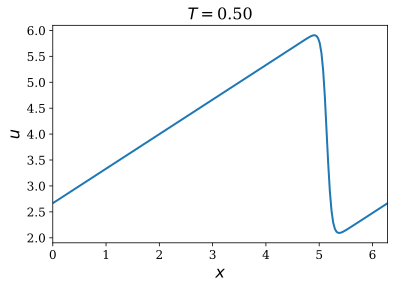

In [6]:
# Copied from http://engineering101.org/1d-burgers-equation/
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
x, nu, t = sp.symbols('x nu t')
phi = sp.exp(-(x-4*t)**2/(4*nu*(t+1.)))+sp.exp(-(x-4*t-2*np.pi)**2/(4*nu*(t+1)))


dphidx = phi.diff(x)
u = -2*nu*dphidx/phi+4.

ufunc = lambdify((t, x, nu),u)
print('d phi/dx=',dphidx)

n = 200
L = 2.*np.pi
dx = L/n
nu = 0.1
nt = 200
dt = dx*nu
T = nt*dt
mesh = np.linspace(dx/2.,L-dx/2,n)
t = 0.
T = 0.5
uexact = np.array([ufunc(T,x,nu) for x in mesh])
plt.plot(mesh,uexact,lw=2)
plt.xlim(0,L)
plt.xlabel(r"$x$", fontdict = fontlabel)
plt.ylabel(r"$u$", fontdict = fontlabel)
plt.title(r"$T=$"+"{0:.2f}".format(T), fontdict=fontlabel)
plt.show

<h2>Definition of Verification</h2>
<p class='alert alert-danger'>
The process of determining that a model implementation accurately represents the developer’s conceptual description of the model and the solution to the model. (AIAA G-077-1998)</p>

<ul>
<li>The code needs to be checked for programming errors. </li>
<li>Numerical errors and their impact on the conservation of mass and energy should be carefully assessed. </li>
<li>For steady problems, the solution needs to converge iteratively. </li>
<li>The solution should be independent of further resolution refinement of the computational grid. </li>
<li>All variables should have a consistent behavior. </li>
</ul>

<h2>Simulation of Burger equation</h2>

To solve the Burger equation, we need to choose a discretization method, here finite difference and then choose numerical schemes for to calculate the three derivatives. The computational domain is as follows:

In [7]:
PDF('figures/1D-grid-u-F.pdf',size=(600,200))

Fig 1. Sketch of the computational domain. The velocity is stored at the center of the cells.

To solve the Burger equation, we consider the following numerical schemes:
<ul>
<li>Advection:
<p class='alert alert-info'>
$$
\left.u\frac{\partial u}{\partial x}\right\vert_{i}\approx u_{i}\frac{\overline{u}_{i+\frac{1}{2}}-\overline{u}_{i-\frac{1}{2}}}{\Delta x}+{\cal O}(\Delta x^n)
$$
</p>
where $\overline{u}_{i+\frac{1}{2}}$ is the interpolated velocity at the face $i+1/2$ of the cell according to:
<p class='alert alert-info'>
$$
\begin{split}
\overline{u}_{i+\frac{1}{2}}&\approx\max\left(0,s_{i+1/2}\right)\left[(1-g_1+g_2)u_{i}+g_1u_{i+1}-g_2u_{i-1}\right]\\
&-\min\left(0,s_{i+1/2}\right)\left[(1-g_1+g_2)u_{i+1}+g_1u_{i}-g_2u_{i+2}\right]+{\cal O}(\Delta x^m)
\end{split}
$$
</p>
and 
$$
s_{i+\frac{1}{2}}=\begin{cases}
1 &\text{ if } \frac{u_{i+1}+u_{i}}{2}>0\\
-1 &\text{ if } \frac{u_{i+1}+u_{i}}{2}<0\\
0 & \text{otherwise}
\end{cases}
\,.
$$
</li>

The interpolation depends on the local direction of the flow velocity. With the exception for the central scheme 'CS' (see below), all other schemes considered in this notebook are called <b>upwind</b> scheme. In the case of advection, information travels with the flow, which means that the velocity, temperature, etc at a given location is influenced by the quantities upstream rather than downstream. This motivates upwind schemes. The function <FONT FACE="courier" style="color:blue">interpolation4advection </FONT> defines a function for 3 upwind schemes and one central scheme.
<h4 style="color:green"> Q1: In the case of CS and US3 (also called quick scheme), derive the truncation errors for the interpolation and the divergence of flux.</h4>

<li>Diffusion:
<p class='alert alert-info'>
$$
\frac{\partial^2 u}{\partial x^2}\approx\frac{u_{i-1}-2u_i+u_{i+1}}{\Delta x^2}+{\cal O}(\Delta x^2)
$$
</p>
The process of diffusion is governed by viscous stresses for momentum or heat flux for temperature. It quantifies the amount of velocity or temperature leaving the system through diffusion. The viscous stress or heat flux are proportional to the gradient of velocity or temperature. For instance, the heat flux is
$$
F_{i+\frac{1}{2}}=-k\frac{T_{i+1}-T_{i}}{\Delta x}
$$
The temperature variation within cell $i$ is therefore (see <a href="https://github.com/yvesdubief/UVM-ME249-CFD/blob/master/ME249-Lecture-0.ipynb">Lecture 0</a>):
$$
\frac{\partial T}{\partial t}\Delta x\Delta y + \left(-k\frac{T_{i+1}-T_{i}}{\Delta x}\right)\Delta y+\left(k\frac{T_{i}-T_{i-1}}{\Delta x}\right)\Delta x=0\,,
$$
which reduces to
$$
\frac{\partial T}{\partial t}=k\frac{T_{i-1}-2T_i+T_{i+1}}{\Delta x^2}\,.
$$
When $\Delta x\rightarrow 0$, you should recognize the heat equation:
$$
\frac{\partial T}{\partial t}=k\frac{\partial^2 T}{\partial x^2}\,.
$$
<h4 style="color:green"> Q2: Demonstrate that the numerical scheme used for the diffusion is second-order accurate in space.</h4>
</li>
<li> Time variation of velocity: We will consider two schemes
<ol>
<li> The Euler scheme:
<p class='alert alert-info'>
\begin{eqnarray}
u_i^{n+1} = u_i^n+\Delta t\left(RHS_i^n\right)
\end{eqnarray}
</p>
</li>
<li> The 2<sup>nd</sup> order Runge Kutta scheme:
<p class='alert alert-info'>
\begin{eqnarray}
u_i^{n+1/2} &=& u_i^n+\frac{\Delta t}{2}\left(RHS_i^n\right)\\
u_i^{n+1} &=& u_i^n+\Delta t\left(RHS_i^{n+1/2}\right)
\end{eqnarray}
</p>
</li>
</ol>
where 
$$
RHS_i^n = -\left.\left(u\frac{\partial u}{\partial x}\right)\right\vert_i^n+\nu\left.\frac{\partial^2 u}{\partial x^2}\right\vert_i^n
$$
<h4 style="color:green"> Q3: Show that this scheme, the 2<sup>nd</sup> Runge-Kutta, is second-order accurate in time.</h4>
</li>
</ul>

In [30]:
Nschemes_advection = 4
Scheme = np.array(['CS','US1','US2','US3'])
g_1 = np.array([1./2.,0.,0.,3./8.])
g_2 = np.array([0.,0.,1./2.,1./8.])


def interpolation4advection(a,N,num_scheme):
    imask = np.where(Scheme == num_scheme)
    g1 = g_1[imask]
    g2 = g_2[imask]
    f=np.zeros(N+1,dtype='float64')
    zero_array = np.zeros(N+1,dtype='float64')
    sign_v = np.zeros(N+1,dtype='float64')
    sign_v[1:N] = np.sign(0.5*(a[0:N-1]+a[1:N]))
    sign_v[0] = np.sign(0.5*(a[N-1]+a[0]))
    sign_v[N] = sign_v[0]
    f[2:N-1] = np.maximum(zero_array[2:N-1],sign_v[2:N-1])*((1.-g1+g2)*a[1:N-2]+g1*a[2:N-1]-g2*a[0:N-3])\
              -np.minimum(zero_array[2:N-1],sign_v[2:N-1])*((1.-g1+g2)*a[2:N-1]+g1*a[1:N-2]-g2*a[3:N])
    f[1] = np.maximum(zero_array[1],sign_v[1])*((1.-g1+g2)*a[0]+g1*a[1]-g2*a[N-1]) \
          -np.minimum(zero_array[1],sign_v[1])*((1.-g1+g2)*a[1]+g1*a[0]-g2*a[2])
    f[0] = np.maximum(zero_array[0],sign_v[0])*((1.-g1+g2)*a[N-1]+g1*a[0]-g2*a[N-2]) \
          -np.minimum(zero_array[0],sign_v[0])*((1.-g1+g2)*a[0]+g1*a[N-1]-g2*a[1])
    f[N] = f[0]
    f[N-1] = np.maximum(zero_array[N-1],sign_v[N-1])*((1.-g1+g2)*a[N-2]+g1*a[N-1]-g2*a[N-3]) \
            -np.minimum(zero_array[N-1],sign_v[N-1])*((1.-g1+g2)*a[N-1]+g1*a[N-2]-g2*a[0])
    return f

table = ListTable()
table.append(['Scheme', '$g_1$', '$g_2$'])
for i in range(4):
    table.append([Scheme[i],g_1[i], g_2[i]])
table

Scheme,$g_1$,$g_2$
CS,0.5,0.0
US1,0.0,0.0
US2,0.0,0.5
US3,0.375,0.125


In [31]:
def diffusion(a,N,dx,nu):
    diff = np.zeros(N,dtype='float64')
    diff[1:N-1] = nu*(a[0:N-2]-2.*a[1:N-1]+a[2:N])/dx**2
    diff[0] = nu*(a[N-1]-2.*a[0]+a[1])/dx**2
    diff[N-1] = nu*(a[N-2]-2.*a[N-1]+a[0])/dx**2
    return diff
    

In [32]:
def divergence(f,N,dz):
    div = np.zeros(N,dtype='float64')
    div[0:N] = (f[1:N+1]-f[0:N])/dx
    return div



In [33]:
Lx = 2.*np.pi
nu = 0.07 
Nx = 400
Nrk = 2
if Nrk == 1:
    rk_coef = np.array([1.],dtype='float64') # Euler
elif Nrk == 2:
    rk_coef = np.array([0.5,1.],dtype='float64') # 2nd order Runge Kutta
    
uexact = np.array([ufunc(T,x,nu) for x in mesh])

umax = np.max(uexact)
umin = np.min(uexact)

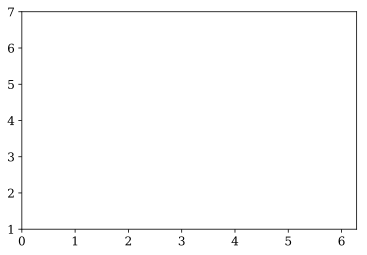

In [20]:
# Preparing for animation
from matplotlib import animation, rc
from IPython.display import HTML
from JSAnimation.IPython_display import display_animation
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, Lx))
ax.set_ylim((np.round(umin)-1, np.round(umax)+1))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [63]:
Lx = 2.*np.pi
Nx = 400
dx = L/Nx
nu = 0.07 
num_scheme = 'US3'

simulation_time = 0.5
Tplot = 0.01 # period of plotting
Nframes = np.int(simulation_time/Tplot)
dt_fixed = 0.001
Nrk = 1
if Nrk == 1:
    rk_coef = np.array([1.],dtype='float64') # Euler
elif Nrk == 2:
    rk_coef = np.array([0.5,1.],dtype='float64') # 2nd order Runge Kutta

x_u = np.linspace(dx/2., Lx-dx/2, Nx,dtype='float64')
x_flux = np.linspace(0., Lx, Nx,dtype='float64')

u = np.zeros(Nx,dtype='float64')           #velocity at cell center
uframes = np.zeros((Nx,Nframes+1),dtype='float64')
u_old = np.zeros(Nx,dtype='float64')
u_face = np.zeros(Nx+1,dtype='float64')    #velocity at faces
flux = np.zeros(Nx+1,dtype='float64')      #advection flux (located on faces)
RHS = np.zeros(Nx,dtype='float64')         #right-hand-side terms (advection+diffusion)

#initialization:
uini = np.array([ufunc(0.,x,nu) for x in x_u],dtype='float64')
u = np.copy(uini)
# dt = np.amin([dx/np.max(np.abs(u)),0.2*dx**2/nu,dt_fixed]) #voodoo magic
dt = dt_fixed
print('time step= %0.5f' %dt)
T = np.dtype('float64')
T = 0. # time
Tp = 0. # plotting time
print(T,simulation_time)
uframes[:,0] = np.copy(u)
iframe = 1
while T < simulation_time:
    uold = u
#     if (np.amax(np.abs(u)) > 0.):
#         dt = np.amin([dx/np.max(np.abs(u)),0.2*dx**2/nu,dt])
#     else:
#         dt = np.amin([0.2*dx**2/nu,dt_fixed])
        
    for irk in range(Nrk):
        u_face = interpolation4advection(u,Nx,num_scheme)
        RHS[0:Nx] = -u[0:Nx]*divergence(u_face,Nx,dx)
        RHS += diffusion(u,Nx,dx,nu)
        u = uold + rk_coef[irk]*dt*RHS
    T += dt
    Tp += dt
    if (Tp >= Tplot):
        uframes[:,iframe] = np.copy(u)
#         plt.plot(x_u,u,lw=2,label='simu')
#         plt.plot(x_u,uini,lw=2,label='ini')
#         uexact = np.array([ufunc(T,x,nu) for x in x_u],dtype='float64')
#         plt.plot(x_u,uexact,'r--', lw=2,label='exact')
#         plt.xlabel('$x$', fontdict = font)
#         plt.ylabel('$u$', fontdict = font)
#         plt.xlim(0,L)
#         plt.legend(loc=3, bbox_to_anchor=[0, 1],
#            ncol=3, shadow=True, fancybox=True)
#         plt.show()
#         clear_output(wait=True)
        iframe += 1
        Tp = 0.



time step= 0.00100
0.0 0.5



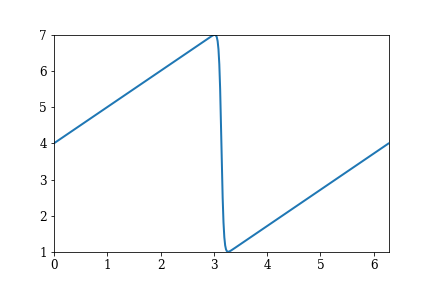
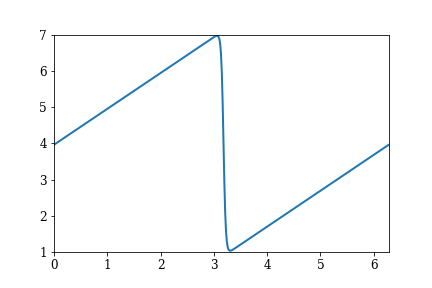
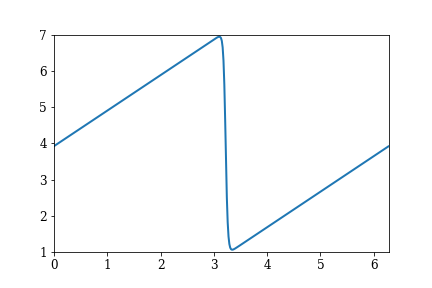
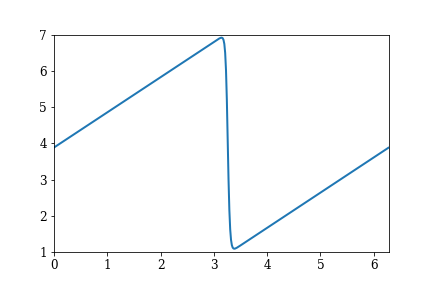
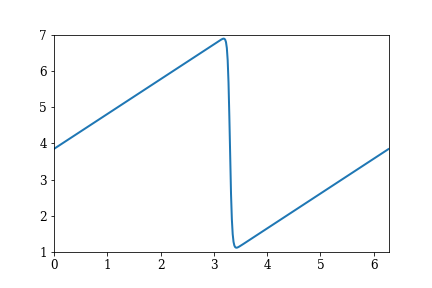
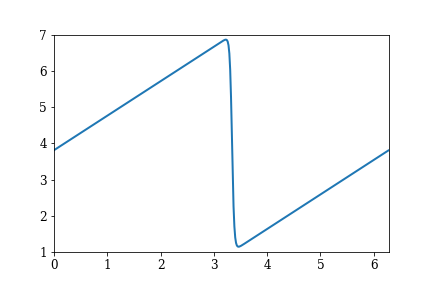
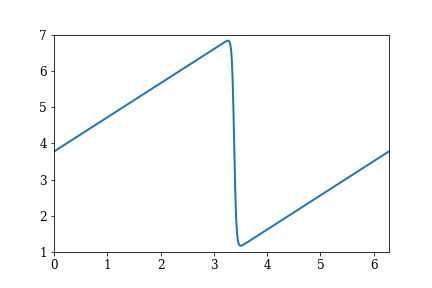
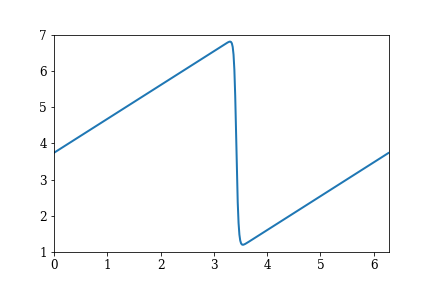
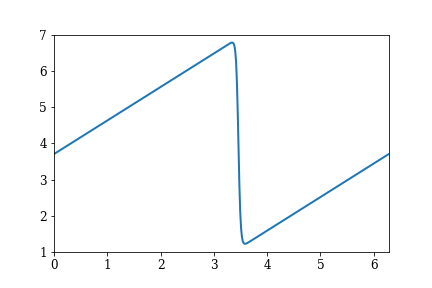
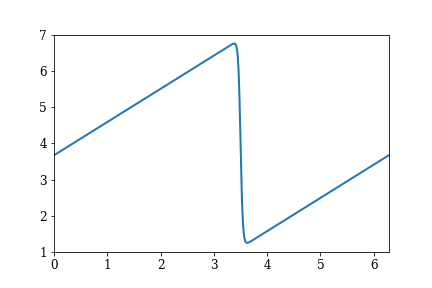
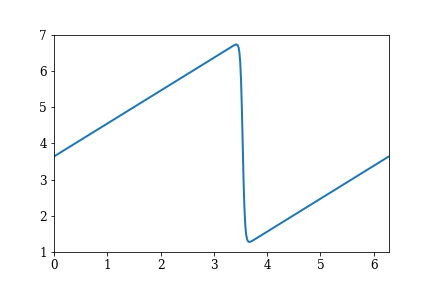
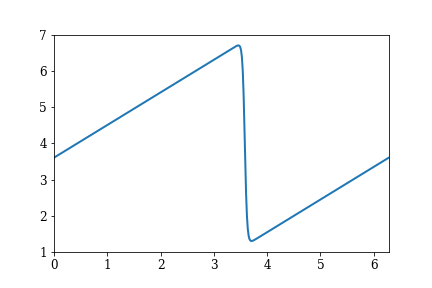
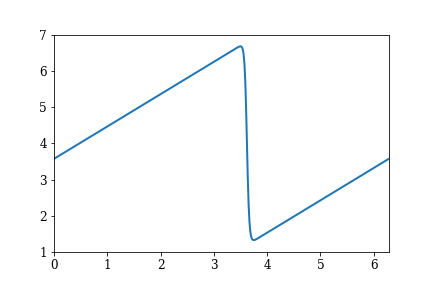
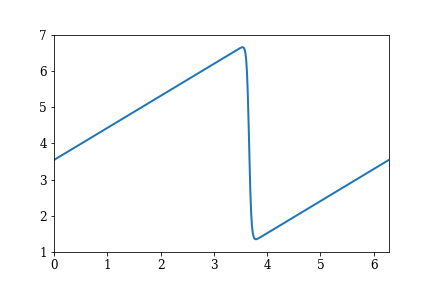
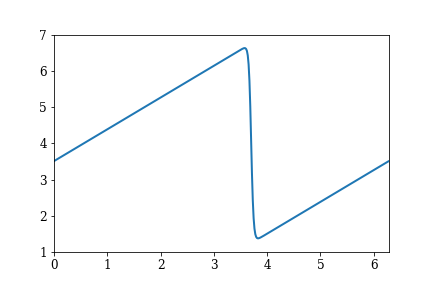
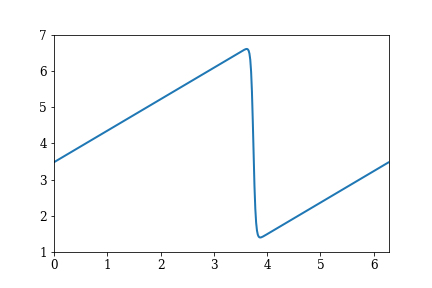
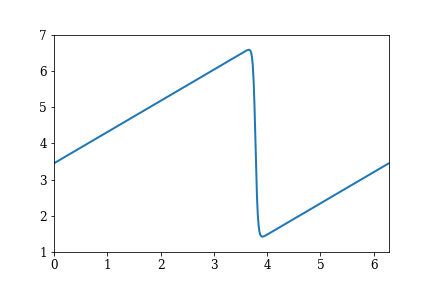
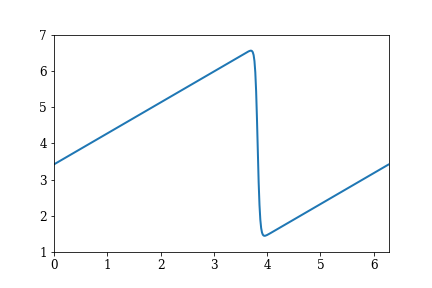
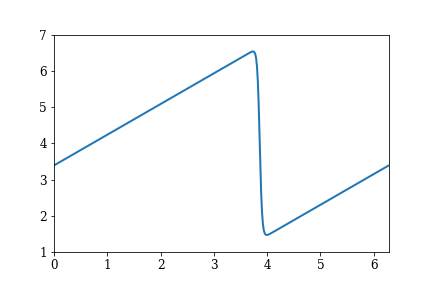
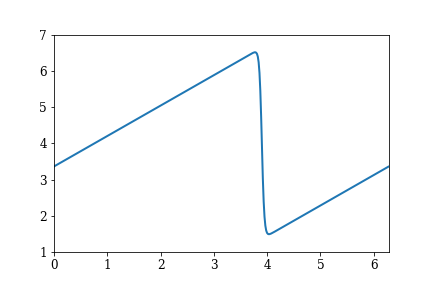
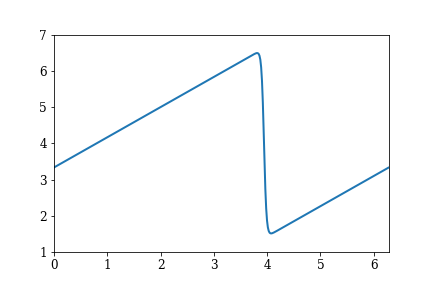
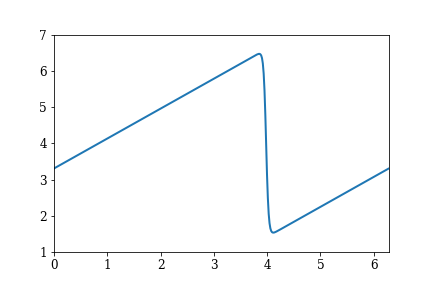
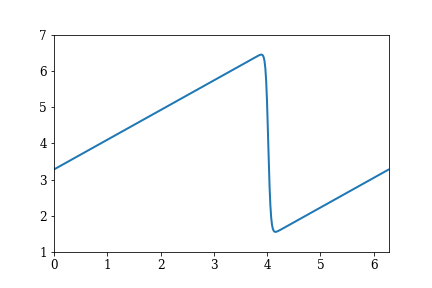
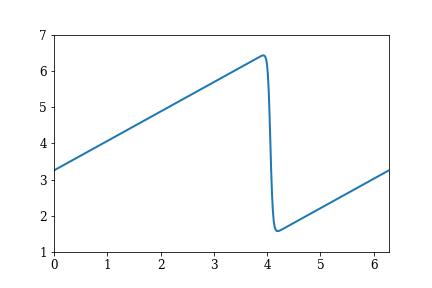
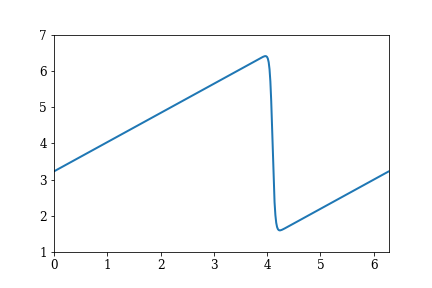
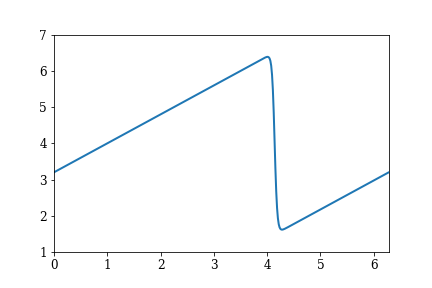
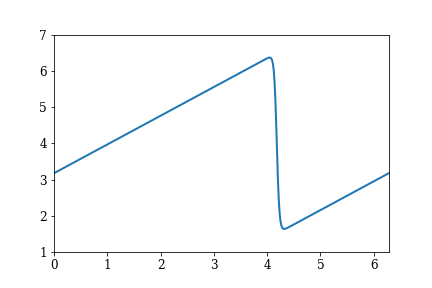
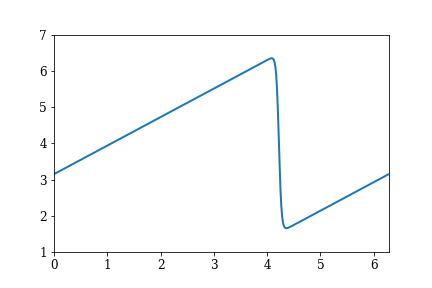
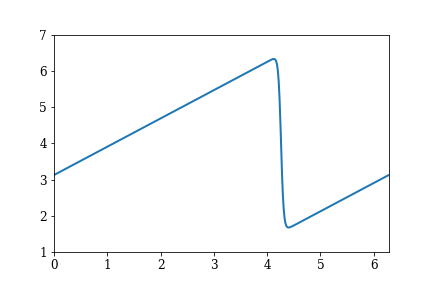
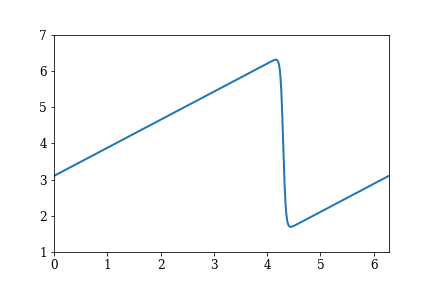
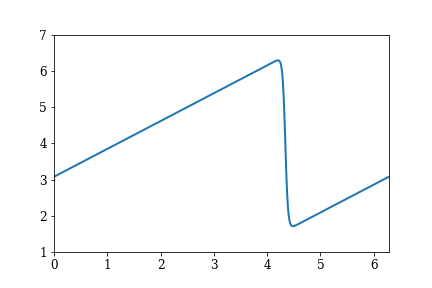
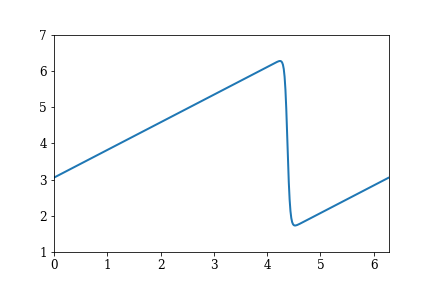
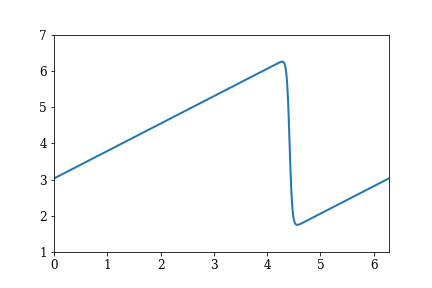
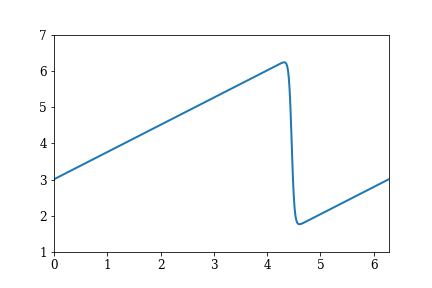
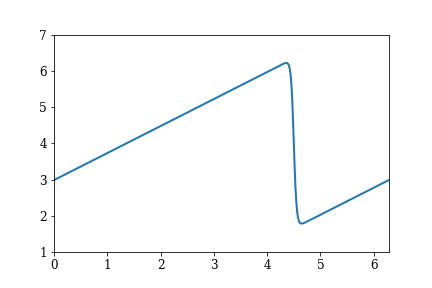
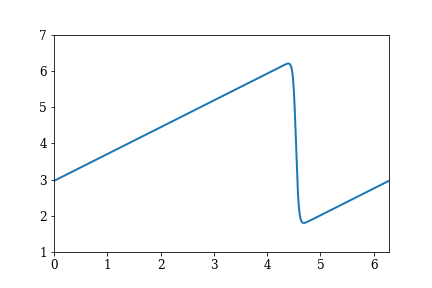
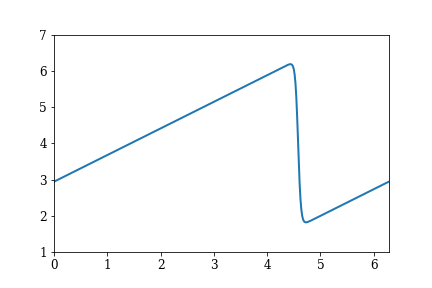
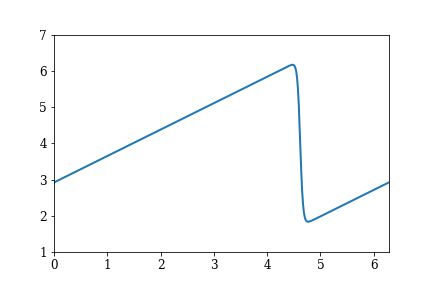
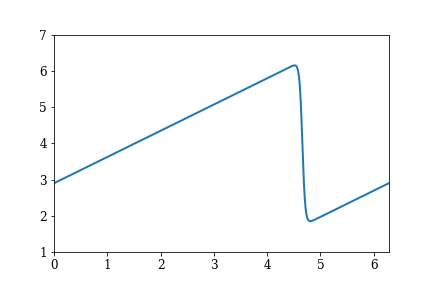
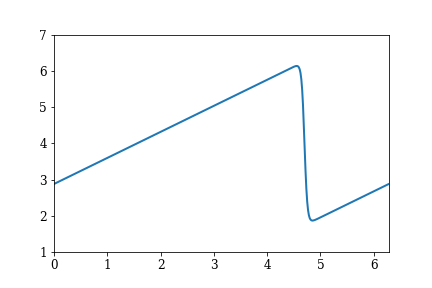
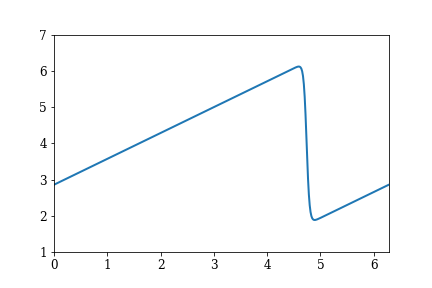
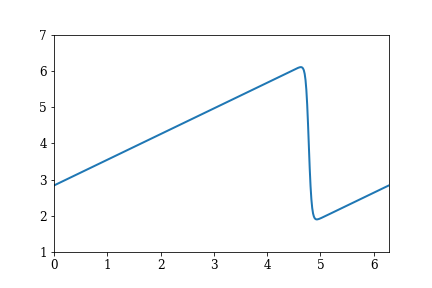
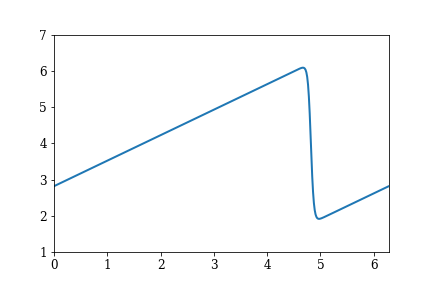
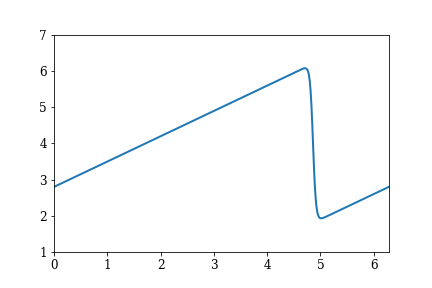
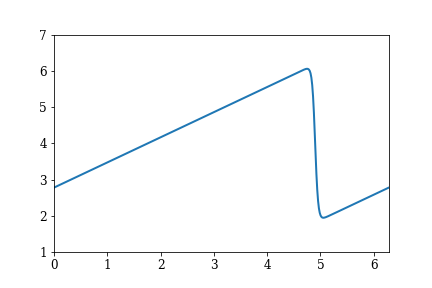
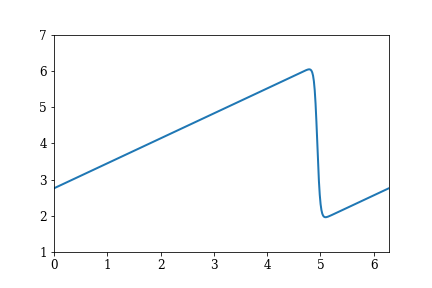
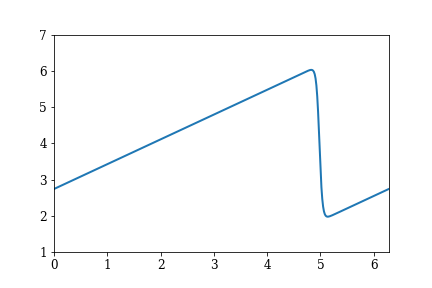
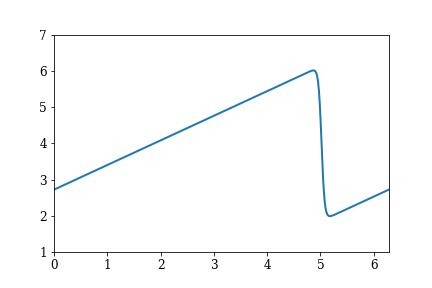
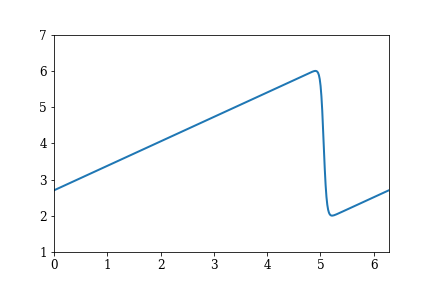
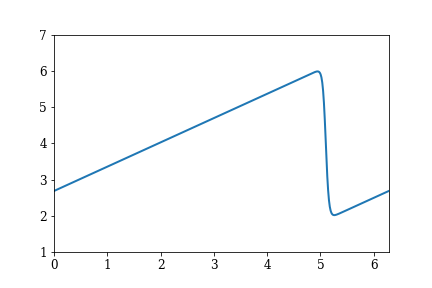

In [64]:
def animate(i):
    line.set_data(x_u, uframes[:,i])
    return (line,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nframes, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

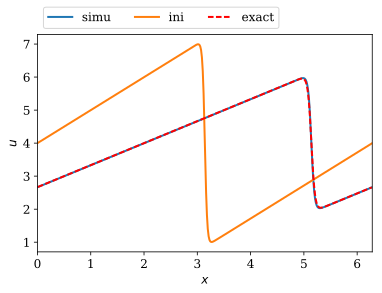

In [65]:
plt.plot(x_u,u,lw=2,label='simu')
plt.plot(x_u,uini,lw=2,label='ini')
uexact = np.array([ufunc(T,x,nu) for x in x_u],dtype='float64')
plt.plot(x_u,uexact,'r--', lw=2,label='exact')
plt.xlabel('$x$', fontdict = font)
plt.ylabel('$u$', fontdict = font)
plt.xlim(0,L)
plt.legend(loc=3, bbox_to_anchor=[0, 1],
   ncol=3, shadow=False, fancybox=True)
plt.show()

In [66]:
Lx = 2.*np.pi
simulation_time = 0.5
nu = 0.07 
dt_fixed = 0.0001
Nresolution = 5
resolution = np.array([50, 100, 250, 500, 1000],dtype='int32')
deltax = np.zeros(2)
deltax = Lx/resolution
print(deltax)

L2norm = np.zeros((Nresolution,Nschemes_advection,2))

for Nrk in np.array([1, 2]):
    print(Nrk)
    if Nrk == 1:
        rk_coef = np.array([1.],dtype='float64') # Euler
    elif Nrk == 2:
        rk_coef = np.array([0.5,1.],dtype='float64') # 2nd order Runge Kutta
    ires = -1
    for Nx in resolution:
        #print(Nx)
        ires += 1
        dx = L/Nx
        x_u = np.linspace(dx/2., Lx-dx/2, Nx,dtype='float64')
        x_flux = np.linspace(0., Lx, Nx,dtype='float64')
        u = np.zeros(Nx,dtype='float64')           #velocity at cell center
        u_old = np.zeros(Nx,dtype='float64')
        u_face = np.zeros(Nx+1,dtype='float64')    #velocity at faces
        flux = np.zeros(Nx+1,dtype='float64')      #advection flux (located on faces)
        RHS = np.zeros(Nx,dtype='float64')         #right-hand-side terms (advection+diffusion)
        ischeme = -1
        for num_scheme in Scheme:
            #print(num_scheme)
            ischeme += 1
            #initialization:
            uini = np.array([ufunc(0.,x,nu) for x in x_u],dtype='float64')
            u = uini
            dt = np.amin([dx/np.max(np.abs(u)),0.2*dx**2/nu,dt_fixed]) #voodoo magic
            T = np.dtype('float64')
            T = 0. # time
            while T < simulation_time:
                uold = u
                if (np.amax(np.abs(u)) > 0.):
                    dt = np.amin([dx/np.max(np.abs(u)),0.2*dx**2/nu,dt])
                else:
                    dt = np.amin([0.2*dx**2/nu,dt_fixed])
        
                for irk in range(Nrk):
                    u_face = interpolation4advection(u,Nx,num_scheme)
                    RHS[0:Nx] = -u[0:Nx]*divergence(u_face,Nx,dx)
                    RHS += diffusion(u,Nx,dx,nu)
                    u = uold + rk_coef[irk]*dt*RHS
                T += dt
            uexact = np.array([ufunc(T,x,nu) for x in x_u],dtype='float64')
            #L2norm[ires,ischeme,Nrk] = np.linalg.norm(u-uexact)
            L2norm[ires,ischeme,Nrk-1] = np.sqrt(np.sum(np.power(u-uexact,2))/Nx)
print('Done')



[ 0.12566371  0.06283185  0.02513274  0.01256637  0.00628319]
1
2
Done


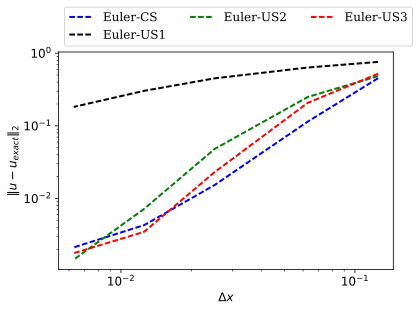

In [67]:
Nrk = 1
plt.loglog(deltax,L2norm[:,0,Nrk-1],'b--',lw=2,label='Euler-CS')
plt.loglog(deltax,L2norm[:,1,Nrk-1],'k--',lw=2,label='Euler-US1')
plt.loglog(deltax,L2norm[:,2,Nrk-1],'g--',lw=2,label='Euler-US2')
plt.loglog(deltax,L2norm[:,3,Nrk-1],'r--',lw=2,label='Euler-US3')
plt.xlabel('$\Delta x$', fontdict = font)
plt.ylabel('$\Vert u-u_{exact}\Vert_2$', fontdict = font)
#plt.xlim(0,L)
plt.legend(loc=3, bbox_to_anchor=[0, 1],
           ncol=3, shadow=False, fancybox=True)
plt.show()

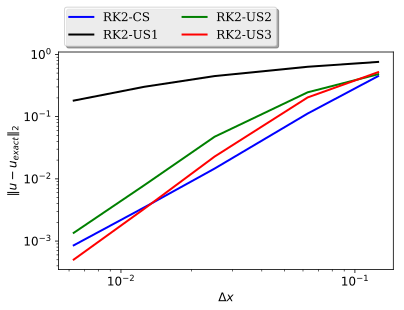

In [68]:
Nrk = 2
plt.loglog(deltax,L2norm[:,0,Nrk-1],'b-',lw=2,label='RK2-CS')
plt.loglog(deltax,L2norm[:,1,Nrk-1],'k-',lw=2,label='RK2-US1')
plt.loglog(deltax,L2norm[:,2,Nrk-1],'g-',lw=2,label='RK2-US2')
plt.loglog(deltax,L2norm[:,3,Nrk-1],'r-',lw=2,label='RK2-US3')
plt.xlabel('$\Delta x$', fontdict = font)
plt.ylabel('$\Vert u-u_{exact}\Vert_2$', fontdict = font)
#plt.xlim(0,L)
plt.legend(loc=3, bbox_to_anchor=[0, 1],
           ncol=2, shadow=False, fancybox=True)
plt.show()

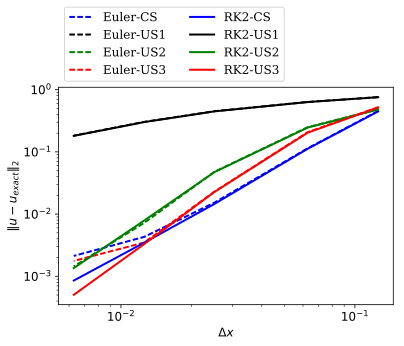

In [69]:
Nrk = 1
plt.loglog(deltax,L2norm[:,0,Nrk-1],'b--',lw=2,label='Euler-CS')
plt.loglog(deltax,L2norm[:,1,Nrk-1],'k--',lw=2,label='Euler-US1')
plt.loglog(deltax,L2norm[:,2,Nrk-1],'g--',lw=2,label='Euler-US2')
plt.loglog(deltax,L2norm[:,3,Nrk-1],'r--',lw=2,label='Euler-US3')
Nrk = 2
plt.loglog(deltax,L2norm[:,0,Nrk-1],'b-',lw=2,label='RK2-CS')
plt.loglog(deltax,L2norm[:,1,Nrk-1],'k-',lw=2,label='RK2-US1')
plt.loglog(deltax,L2norm[:,2,Nrk-1],'g-',lw=2,label='RK2-US2')
plt.loglog(deltax,L2norm[:,3,Nrk-1],'r-',lw=2,label='RK2-US3')
plt.xlabel('$\Delta x$', fontdict = font)
plt.ylabel('$\Vert u-u_{exact}\Vert_2$', fontdict = font)
#plt.xlim(0,L)
plt.legend(loc=3, bbox_to_anchor=[0, 1],
           ncol=2, shadow=False, fancybox=True)
plt.show()

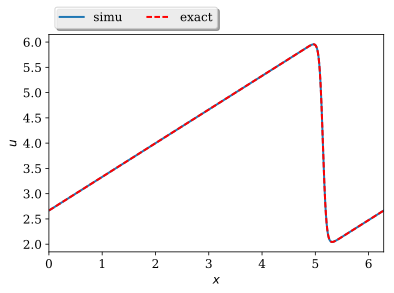

In [70]:
plt.plot(x_u,u,label='simu',lw=2)
#plt.plot(x_u,uini,label='ini',lw=2)
uexact = np.array([ufunc(T,x,nu) for x in x_u],dtype='float64')
plt.plot(x_u,uexact,'r--',label='exact',lw=2)
plt.xlabel('$x$', fontdict = font)
plt.ylabel('$u$', fontdict = font)
plt.xlim(0,L)
plt.legend(loc=3, bbox_to_anchor=[0, 1],
           ncol=3, shadow=True, fancybox=True)
plt.show()